In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='10_class_ds.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('10_class_ds.zip')
f.keys()
!unzip "10_class_ds.zip"

Streaming output truncated to the last 5000 lines.
  inflating: 10_class_ds/drusen/_all_DRUSEN-8870525-3_1.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-8870525-3_2.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-8870525-3_3.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-8870525-3_4.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-8870525-3_5.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9049813-1_0.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9049813-1_1.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9049813-1_2.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9049813-1_3.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9049813-1_4.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9049813-1_5.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9059831-1_0.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9059831-1_1.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9059831-1_2.jpg  
  inflating: 10_class_ds/drusen/_all_DRUSEN-9059831-1_3.jpg  
  inflating: 10_cla

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [ ]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [ ]:
data_dir = '/content/10_class_ds'


train_df, valid_df, test_df = split_data(data_dir)

batch_size = 40

train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)


Found 8877 validated image filenames belonging to 10 classes.
Found 1110 validated image filenames belonging to 10 classes.
Found 1110 validated image filenames belonging to 10 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomZoom(height_factor=0.2)

    ],
    name="img_augmentation",
)

Found 11097 files belonging to 10 classes.


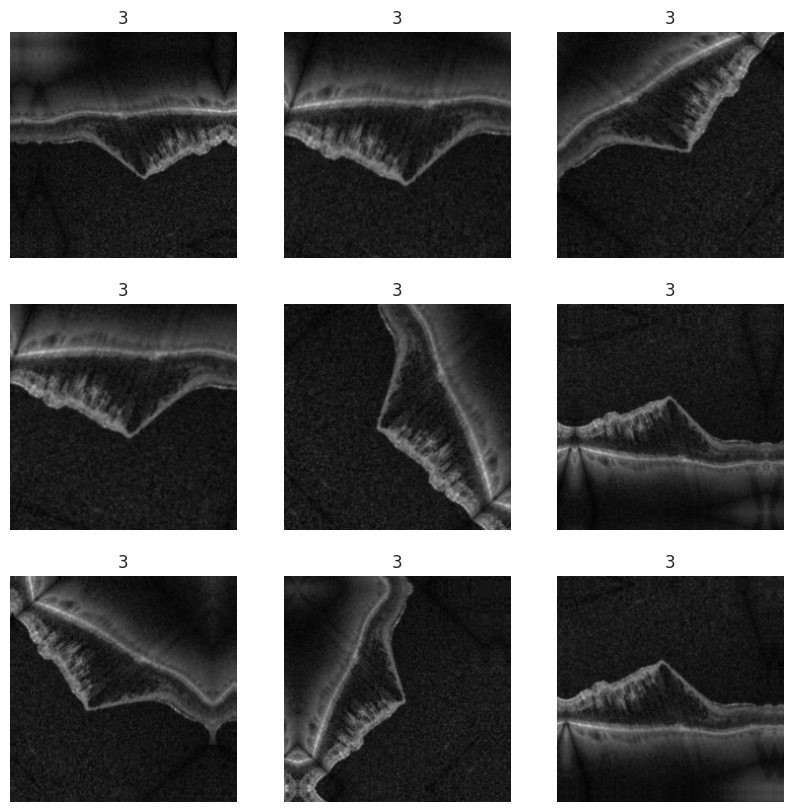

In [ ]:
import numpy as np

dataset = tf. keras.preprocessing. image_dataset_from_directory(
'/content/10_class_ds',
shuffle=True,
image_size = (224, 224) ,
batch_size=32
)

for images, labels in dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = img_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


base_model = tf.keras.applications.xception.Xception(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 21396786 (81.62 MB)
Trainable params: 21338

In [ ]:
history = model.fit(train_gen, epochs= 50,
                    validation_data= valid_gen)

Epoch 1/50
222/222 [==============================] - 182s 643ms/step - loss: 6.1645 - accuracy: 0.8869 - val_loss: 4.1358 - val_accuracy: 0.9658
Epoch 2/50
222/222 [==============================] - 143s 642ms/step - loss: 3.0287 - accuracy: 0.9614 - val_loss: 2.0851 - val_accuracy: 0.9658
Epoch 3/50
222/222 [==============================] - 138s 619ms/step - loss: 1.5318 - accuracy: 0.9744 - val_loss: 1.0617 - val_accuracy: 0.9685
Epoch 4/50
222/222 [==============================] - 138s 621ms/step - loss: 0.8170 - accuracy: 0.9786 - val_loss: 0.6316 - val_accuracy: 0.9568
Epoch 5/50
222/222 [==============================] - 138s 620ms/step - loss: 0.4905 - accuracy: 0.9837 - val_loss: 0.4233 - val_accuracy: 0.9703
Epoch 6/50
222/222 [==============================] - 138s 620ms/step - loss: 0.3515 - accuracy: 0.9870 - val_loss: 0.3357 - val_accuracy: 0.9748
Epoch 7/50
222/222 [==============================] - 137s 619ms/step - loss: 0.2978 - accuracy: 0.9879 - val_loss: 0.2892 -

In [ ]:
dataset = '/content/10_class_ds'

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

validation_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=.10,
                                                                 subset='validation',
                                                                 seed=66)

Found 11097 files belonging to 10 classes.
Using 1109 files for validation.


In [ ]:
class_names = validation_dataset.class_names
class_names

['Choroidal neovascularization',
 'acrima',
 'cataract',
 'diabetic_macular_edema_(dme)',
 'diabetic_retinopathy',
 'drusen',
 'glaucoma',
 'normal',
 'odir_5k',
 'origa']

first image to predict
actual label: acrima
1/1 [==============================] - 0s 33ms/step
predicted label: acrima


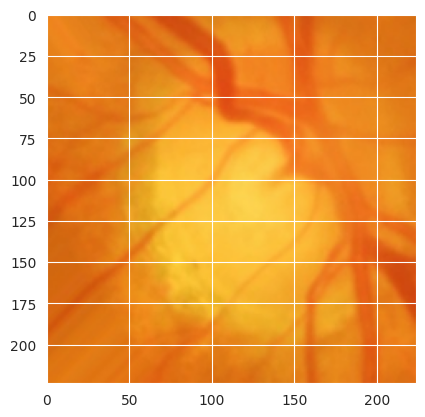

In [ ]:
import numpy as np
for images_batch, labels_batch in validation_dataset.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 34ms/step


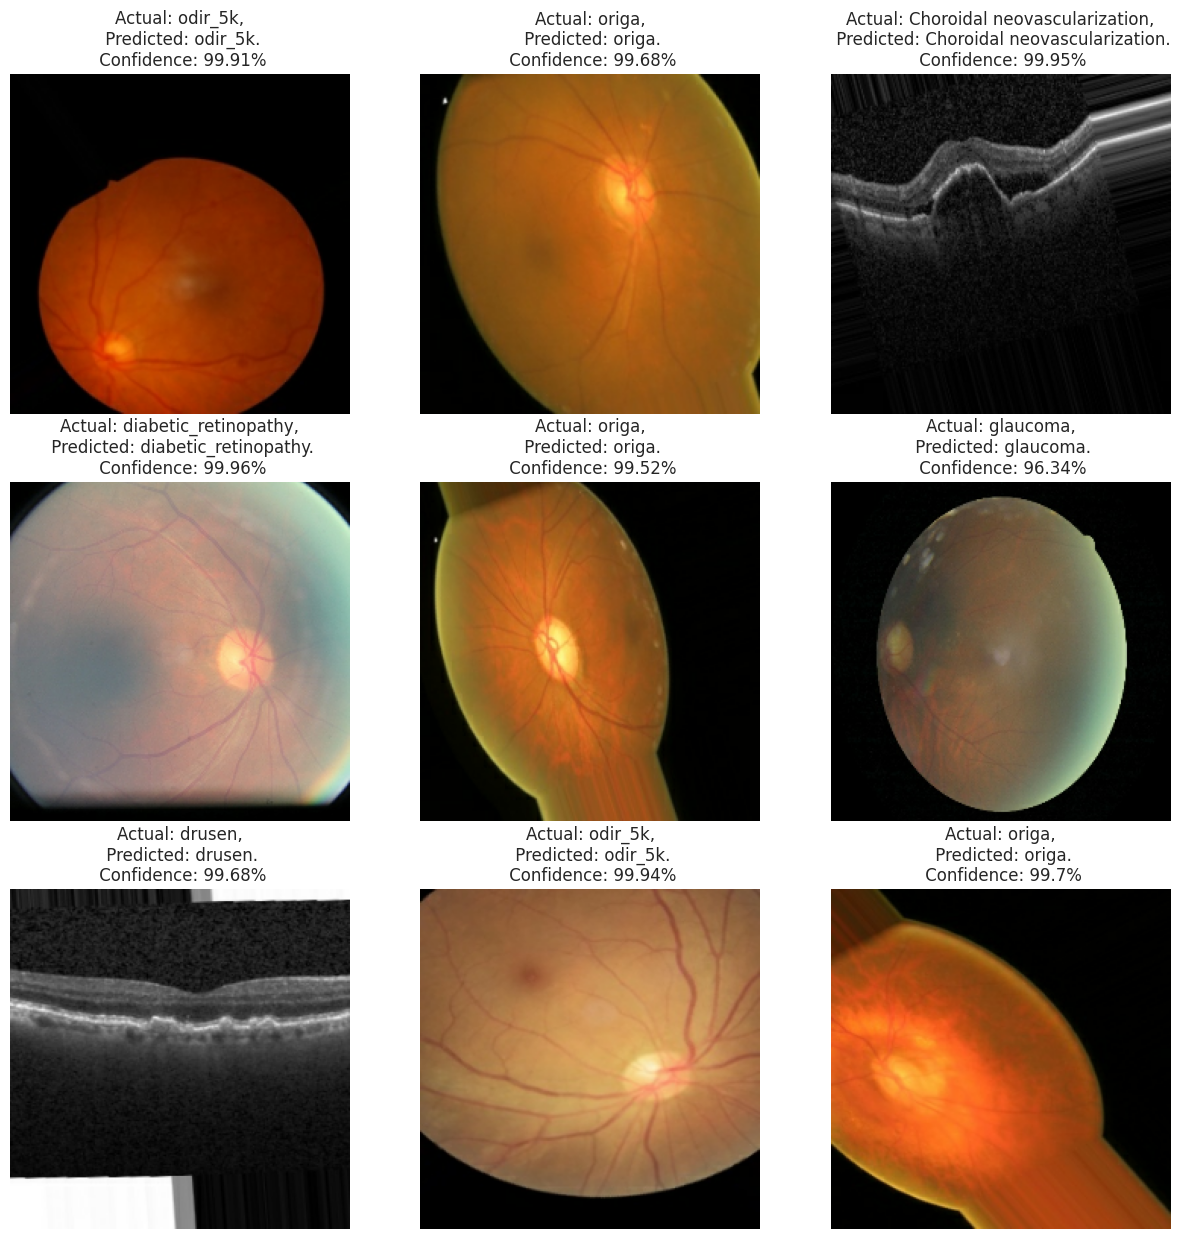

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")